In [1]:
import multiprocessing
import os
from re import A
from typing import ItemsView

from py import log
os.environ['PYTHONDONTWRITEBYTECODE'] = '1'
from xtquant import xttrader
from xtquant.xttrader import XtQuantTrader, XtQuantTraderCallback
from xtquant.xttype import StockAccount
from xtquant import xtconstant
import pandas_market_calendars as mcal
import pandas as pd
import akshare as ak

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
def plot(df, column):
    
    # 设置中文字体
    mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为 SimHei
    mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    # 假设这是你的DataFrame，其中包含收益

    # 绘制收益曲线
    # 将日期列转换为日期类型
    # df['date'] = pd.to_datetime(df['date'])

    # # 设置日期列为索引
    # df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    # 绘制收益曲线
    plt.figure(figsize=(10, 6))  # 设置图表大小
    plt.plot(df.index, df[column], label='Return')
    plt.title('收益曲线')
    plt.xlabel('日期')
    plt.ylabel('收益率')
    plt.legend()  # 显示图例
    plt.grid(True)  # 显示网格线

    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

    plt.show()

d:\anaconda3\envs\python3.8\lib\site-packages\exchange_calendars\exchange_calendar.py:2345: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


In [ ]:
from xtquant import xtdatacenter as xtdc
xtdc.set_token("26e6009f4de3bfb2ae4b89763f255300e96d6912")

print('xtdc.init')
xtdc.init() # 初始化行情模块，加载合约数据，会需要大约十几秒的时间
print('done')

from xtquant import xtdata 

xtdc.init


In [ ]:
import sys
sys.path.append(r"D:\workspace\TradeX\ezMoney")
from http_request import build_http_request
from data_class import category_rank_class
def get_ranked_category_infos(date_key, except_is_ppp = True, except_is_track = False, gap = 10):
    # build_http_request.check_user_alive()
    categoryRankList = category_rank_class.build_category_rank_sort_list(date_key)
    block_rank_list = []
    for item in categoryRankList:
        if item == None:
            continue
        if item.stockType == 'industry':
            isPpp = item.isPpp
            num = item.num
            numChange = item.numChange
            isTrack = item.isTrack
            stockCode = item.categoryCode
            r  = {
                'isPpp': isPpp,
                'num': num,
                'numChange': numChange,
                'isTrack': isTrack,
                'blockCode': stockCode
            }
            block_rank_list.append(r)
        if item.blockRankList == None:
            continue
        block_rank_list.extend(item.blockRankList)

    if except_is_ppp:
        block_rank_list = [item for item in block_rank_list if not item['isPpp']]
    if except_is_track:
        block_rank_list = [item for item in block_rank_list if not item['isTrack']]

    sorted_block_rank_list = sorted(block_rank_list, key=lambda x: (-x['num'], -x['numChange']))
    rank_dict = {}
    prev_num = None
    current_rank = 1

    for idx, item in enumerate(sorted_block_rank_list):
        code = item['blockCode']
        num = item['num']

        if idx == 0:
            # 第一个元素直接赋初始排名
            rank_dict[code] = current_rank
            prev_num = num
            continue

        delta = 0
        diff = prev_num - num

        # 判断差值规则
        if abs(diff) <= 0.0001:
            delta = 0
        else:
            if gap == 0:
                delta = 1
            else:
                if diff > gap:
                    delta = int(diff // gap) + 1
                else:
                    delta = 1
        current_rank += delta
        rank_dict[code] = current_rank
        prev_num = num
    return rank_dict

In [ ]:


hd_pct = 0.001

strategy_name = '中位低吸'
days = 3
#胜率最高
params = [
              {
        "filtered": True,
        "fx_filtered": True,
        "topn": 1,
        "top_fx": 3,
        "top_cx": 1,
        "only_fx": True,
        "enbale_industry": False,
        "empty_priority": True
      }
        ]

filter_count = 0
filter_amount = 8000000
gap = 0
rank_filter = True

In [ ]:
def get_first_tick_trade_amount(stock_code, datekey):
    import datetime
    import pandas as pd

    today = datetime.datetime.strptime(datekey, '%Y-%m-%d').date()

    time_0930 = datetime.time(9, 20, 0)

    dt_0930 = datetime.datetime.combine(today, time_0930)

    timestamp_0930 = dt_0930.timestamp()

    time_09305 = datetime.time(9, 26, 0)

    dt_09305 = datetime.datetime.combine(today, time_09305)

    timestamp_09305 = dt_09305.timestamp()

    tims = int(timestamp_0930*1000)

    tims5 = int(timestamp_09305*1000)
    import numpy as np
    n_data_key = datekey.replace('-', '')
    xtdata.download_history_data(stock_code, 'tick', n_data_key, n_data_key)
    all_tick_data = xtdata.get_market_data(stock_list=[stock_code], period='tick', start_time=n_data_key, end_time=n_data_key)

    # 假设 all_tick_data['000759.SZ'] 是 numpy.void 数组
    if isinstance(all_tick_data[stock_code], np.ndarray) and all_tick_data[stock_code].dtype.type is np.void:
        df = pd.DataFrame(all_tick_data[stock_code].tolist(), columns=all_tick_data[stock_code].dtype.names)
    else:
        raise

    filtered_df = df[(df['time'] >= tims) & (df['time'] <= tims5)]

    # 按 time 列升序排序
    sorted_df = filtered_df.sort_values(by='time')

    # 取 time 最小的行
    min_time_row = sorted_df.tail(1)

    amount = min_time_row['amount']

    if len(amount) == 1:
        real_amount = amount.item()
    else:
        raise Exception(f"{stock_code}-{datekey}")

    return real_amount

def get_real_open_price(stock_code, datekey):
    import datetime

    today = datetime.datetime.strptime(datekey, '%Y-%m-%d').date()

    time_0930 = datetime.time(9, 29, 0)

    dt_0930 = datetime.datetime.combine(today, time_0930)

    timestamp_0930 = dt_0930.timestamp()

    time_09305 = datetime.time(9, 30, 5)

    dt_09305 = datetime.datetime.combine(today, time_09305)

    timestamp_09305 = dt_09305.timestamp()

    tims = int(timestamp_0930*1000)

    tims5 = int(timestamp_09305*1000)
    import numpy as np
    n_data_key = datekey.replace('-', '')
    xtdata.download_history_data(stock_code, 'tick', n_data_key, n_data_key)
    all_tick_data = xtdata.get_market_data(stock_list=[stock_code], period='tick', start_time=n_data_key, end_time=n_data_key)

    # 假设 all_tick_data['000759.SZ'] 是 numpy.void 数组
    if isinstance(all_tick_data[stock_code], np.ndarray) and all_tick_data[stock_code].dtype.type is np.void:
        df = pd.DataFrame(all_tick_data[stock_code].tolist(), columns=all_tick_data[stock_code].dtype.names)
    else:
        raise

    filtered_df = df[(df['time'] >= tims) & (df['time'] <= tims5)]

    # 按 time 列升序排序
    sorted_df = filtered_df.sort_values(by='time')

    # 取 time 最小的行
    min_time_row = sorted_df.head(1)

    last_price = min_time_row['lastPrice']

    # 检查 Series 是否只有一个元素
    if len(last_price) == 1:
        last_price_real = last_price.item()
    else:
        raise Exception(f"{stock_code}-{datekey}")

    return last_price_real

In [ ]:
all_stocks = {}
all_stocks_info = xtdata.get_stock_list_in_sector('沪深A股')
for stock in all_stocks_info:
    if stock.startswith('60') or stock.startswith('00'):
        cde = stock.split('.')[0]
        all_stocks[cde] = stock

def group_filter_fx(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False, filter_amount = filter_amount, all_stocks = all_stocks):
    if filter_amount > 0:
        masks = []
        first_tick_amounts = []  # 存储每行的 first_tick_amount
        
        # 遍历每一行并计算值
        for _, row in group.iterrows():
            if row['stock_code'].split('.')[0] not in all_stocks:
                masks.append(False)
                first_tick_amounts.append(0)
                continue
            stock_code = all_stocks[row['stock_code'].split('.')[0]]
            date_key = row['date_key']
                
            # 计算 first_tick_amount
            first_tick_amount = get_first_tick_trade_amount(stock_code, date_key)
            first_tick_amounts.append(first_tick_amount)  # 记录值
            if first_tick_amount > filter_amount:
                masks.append(True)
            else:
                print(f"过滤股票 {stock_code} 日期 {date_key} 过滤原因： first_tick_amount {first_tick_amount}")
                masks.append(False)
                global filter_count
                filter_count = filter_count + 1
            # 生成过滤掩码
        
        # 将 first_tick_amount 添加到原始分组中
        group = group.copy()  # 避免 SettingWithCopyWarning
        group['first_tick_amount'] = first_tick_amounts
        
        # 应用过滤
        group = group[masks]
            
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()
            
            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row

            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            else:
                category_filtered = group[(group['max_block_category_rank'] <= top_fx) & ((group['max_block_code_rank'] <= top_cx) | (group['max_industry_code_rank'] <= top_cx))]
                if len(category_filtered) == 0:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row

                result = category_filtered[category_filtered['max_block_code_rank'] == category_filtered['max_block_code_rank'].min()]
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row



def group_filter(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False, filter_amount = filter_amount, all_stocks = all_stocks):
    if filter_amount > 0:
        masks = []
        first_tick_amounts = []  # 存储每行的 first_tick_amount
        
        # 遍历每一行并计算值
        for _, row in group.iterrows():
            stock_code = all_stocks[row['stock_code'].split('.')[0]]
            date_key = row['date_key']
            if row['stock_code'].split('.')[0] not in all_stocks:
                masks.append(False)
                first_tick_amounts.append(0)
                continue
            # 计算 first_tick_amount
            first_tick_amount = get_first_tick_trade_amount(stock_code, date_key)
            first_tick_amounts.append(first_tick_amount)  # 记录值
            if first_tick_amount > filter_amount:
                masks.append(True)
            else:
                print(f"过滤股票 {stock_code} 日期 {date_key} 过滤原因： first_tick_amount {first_tick_amount}")
                masks.append(False)
                global filter_count
                filter_count = filter_count + 1
            # 生成过滤掩码
        
        # 将 first_tick_amount 添加到原始分组中
        group = group.copy()  # 避免 SettingWithCopyWarning
        group['first_tick_amount'] = first_tick_amounts
        
        # 应用过滤
        group = group[masks]
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()

            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            
            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            elif min_category_rank < 0:
                category_filtered = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                if not category_filtered.empty and len(category_filtered) > 0:
                    category_filtered = category_filtered[category_filtered['stock_rank'] == category_filtered['stock_rank'].min()]
                    category_filtered['return'] = category_filtered['next_day_open_price'] / category_filtered['open_price'] - 1
                    category_filtered['real_return'] = category_filtered['return'] - hd_pct
                    category_filtered['close_return'] = category_filtered['next_day_close_price'] / category_filtered['open_price'] - 1
                    category_filtered['close_real_return'] = category_filtered['close_return'] - hd_pct
                    return category_filtered
                else:
                    rank_one_row = group[group['max_block_category_rank'] == min_category_rank]
                    if len(rank_one_row) > 0:
                        rank_one_row = rank_one_row[rank_one_row['stock_rank'] == rank_one_row['stock_rank'].min()].copy()
                        if not rank_one_row.empty and len(rank_one_row) > 0:
                            rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                            rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                            return rank_one_row
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                    else:
                        raise Exception("No data.")
            else:
                result = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                
                if result.empty or len(result) < 1:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row


***** xtdata连接成功 *****
服务信息: {'tag': 'xtquant', 'version': '1.0'}
服务地址: 127.0.0.1:58609
数据路径: d:\workspace\TradeX\notebook\data\datadir
设置xtdata.enable_hello = False可隐藏此消息



In [ ]:
param0 = params[0]
empty_priority = param0['empty_priority']
del param0['empty_priority']
if empty_priority:
    filter_func = group_filter_fx
else:
    filter_func = group_filter

In [ ]:
import sqlite3
# months = ['202502']
months = ['202409', '202410', '202411', '202412', '202501', '202502', '202503']
# months = ['202409', '202410']
combined_df = pd.DataFrame()
for month in months:
    conn = sqlite3.connect('D:\workspace\TradeX\ezMoney\sqlite_db\strategy_data.db')
    db_name = 'strategy_data_aftermarket_%s' % month
    query = "select * from %s where (sub_strategy_name = '%s') and stock_rank <= %s " % (db_name, strategy_name, days)
    df = pd.read_sql_query(query, conn)
    combined_df = pd.concat([combined_df, df], axis=0)
combined_df = combined_df.reset_index(drop=True)
combined_df

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,...,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,block_category_info,created_at
0,936,2024-09-03,低吸,中位低吸,002426.XSHE,胜利精密,1,"000038.BKDL,000026.BKDL,000014.BKDL,000035.BKD...","885785.DDBK,885840.DDBK,885467.DDBK,886000.DDB...","980365.ZHBK,980357.ZHBK",...,中位低吸,-66.21,-0.97,56,-54.10,-8.41,41,"{""9A0001"": {""realShortLineScore"": 20.72, ""real...","{""000028.BKDL"": {""categoryCode"": ""000028.BKDL""...",2025-02-15 17:42:38
1,961,2024-09-04,低吸,中位低吸,002806.XSHE,华锋股份,1,"000012.BKDL,000035.BKDL,000027.BKDL","885775.DDBK,885999.DDBK,885662.DDBK,885921.DDB...",980372.ZHBK,...,中位低吸,-35.20,31.01,43,-49.43,-1.06,42,"{""9A0001"": {""realShortLineScore"": 26.55, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:43:39
2,962,2024-09-04,低吸,中位低吸,603726.XSHG,朗迪集团,2,,,,...,中位低吸,-35.20,31.01,43,-49.43,-1.06,42,"{""9A0001"": {""realShortLineScore"": 26.55, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:43:39
3,963,2024-09-04,低吸,中位低吸,001319.XSHE,铭科精技,3,"000026.BKDL,000018.BKDL,000027.BKDL","885467.DDBK,885834.DDBK,885999.DDBK,886000.DDB...",980372.ZHBK,...,中位低吸,-35.20,31.01,43,-49.43,-1.06,42,"{""9A0001"": {""realShortLineScore"": 26.55, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 17:43:39
4,1016,2024-09-05,低吸,中位低吸,603189.XSHG,网达软件,1,"000012.BKDL,000008.BKDL,000026.BKDL,000015.BKD...","885980.DDBK,885759.DDBK,886062.DDBK,885472.DDB...","980753.ZHBK,980366.ZHBK",...,中位低吸,-68.59,-33.39,63,-66.71,-15.87,44,"{""9A0001"": {""realShortLineScore"": -12.1, ""real...","{""000003.BKDL"": {""categoryCode"": ""000003.BKDL""...",2025-02-15 17:44:43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,2303,2025-03-17,低吸,中位低吸,002361.XSHE,神剑股份,3,"000038.BKDL,000018.BKDL,000011.BKDL,000027.BKD...","885743.DDBK,885338.DDBK,885650.DDBK,885574.DDB...",980364.ZHBK,...,中位低吸,103.31,5.24,11,6.35,-8.49,18,"{""9A0001"": {""realShortLineScore"": 51.76, ""real...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-03-18 08:00:38
324,2594,2025-03-19,低吸,中位低吸,603912.XSHG,佳力图,1,"000003.BKDL,000006.BKDL,000031.BKDL,000037.BKD...","885520.DDBK,885887.DDBK,885806.DDBK,885362.DDB...",980365.ZHBK,...,中位低吸,69.41,-41.99,13,9.45,-11.44,18,"{""9A0001"": {""realShortLineScore"": 39.04, ""real...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-03-20 08:00:40
325,2638,2025-03-20,低吸,中位低吸,002559.XSHE,亚威股份,1,"000023.BKDL,000018.BKDL,000035.BKDL,000006.BKD...","885743.DDBK,886042.DDBK,885930.DDBK,885517.DDB...",980365.ZHBK,...,中位低吸,18.00,-10.67,19,2.23,5.30,22,"{""9B0002"": {""realShortLineScore"": 28.86, ""real...","{""000033.BKDL"": {""categoryCode"": ""000033.BKDL""...",2025-03-20 08:01:31
326,2639,2025-03-20,低吸,中位低吸,000905.XSHE,厦门港务,2,"000038.BKDL,000026.BKDL,000018.BKDL,000010.BKD...","885338.DDBK,883436.DDBK,886021.DDBK,885694.DDB...",980339.ZHBK,...,中位低吸,18.00,-10.67,19,2.23,5.30,22,"{""9B0002"": {""realShortLineScore"": 28.86, ""real...","{""000033.BKDL"": {""categoryCode"": ""000033.BKDL""...",2025-03-20 08:01:31


In [ ]:
if rank_filter:
    for idx, row in combined_df.iterrows():
        block_category = row['block_category']
        block_codes = row['block_codes']
        industry_code = row['industry_code']
        date_key = row['date_key']
        ranked_block_dict = get_ranked_category_infos(date_key, gap = gap)
        min_rank = 100
        if not block_codes:
            continue
        else:
            for block_code in block_codes.split(','):
                if block_code in ranked_block_dict:
                    rank_this = ranked_block_dict[block_code]
                    min_rank = min(min_rank, rank_this)
        if not industry_code:
            combined_df.loc[idx, 'max_block_code_rank'] = min_rank
            continue
        else:
            i_min_rank = 100
            for i_code in industry_code.split(','):
                if i_code in ranked_block_dict:
                    rank_this = ranked_block_dict[i_code]
                    min_rank = min(min_rank, rank_this)
                    i_min_rank = min(i_min_rank, rank_this)
                    combined_df.loc[idx, 'max_industry_code_rank'] = i_min_rank
            combined_df.loc[idx, 'max_block_code_rank'] = min_rank


In [ ]:
combined_df = combined_df.reset_index(drop=True)

In [ ]:
combined_df = combined_df.drop(['env_json_info', 'block_category_info'], axis=1)
combined_df = combined_df[combined_df['strategy_name'] == '低吸']

In [ ]:
pd.set_option('display.max_columns', None)
combined_df.tail(10)

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at
318,2112,2025-03-14,低吸,中位低吸,002927.XSHE,泰永长征,1,"000003.BKDL,000035.BKDL,000027.BKDL,000004.BKD...","885929.DDBK,885461.DDBK,886001.DDBK,885311.DDB...",980474.ZHBK,3,9,21,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,149.50,282.66,0.0,-0.99,16.05,15.51,-1.0,15.70,15.84,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,83.44,-19.41,15,8.68,-17.93,16,2025-03-17 08:00:41
319,2113,2025-03-14,低吸,中位低吸,002760.XSHE,凤形股份,2,"000023.BKDL,000013.BKDL","885739.DDBK,885802.DDBK,885700.DDBK",980365.ZHBK,2,2,11,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,127.17,241.21,0.0,-6.10,21.87,21.56,-1.0,21.21,21.57,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,83.44,-19.41,15,8.68,-17.93,16,2025-03-17 08:00:41
320,2114,2025-03-14,低吸,中位低吸,603958.XSHG,哈森股份,3,"000010.BKDL,000034.BKDL,000033.BKDL","886100.DDBK,885420.DDBK,885941.DDBK,885784.DDBK",,4,1,-1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,104.22,241.85,0.0,-6.13,18.52,17.76,-1.0,16.69,16.73,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,83.44,-19.41,15,8.68,-17.93,16,2025-03-17 08:00:41
321,2301,2025-03-17,低吸,中位低吸,603206.XSHG,嘉环科技,1,"000012.BKDL,000003.BKDL,000035.BKDL,000011.BKD...","886100.DDBK,885919.DDBK,885461.DDBK,885956.DDB...","980753.ZHBK,980376.ZHBK",2,6,11,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,471.70,299.20,0.0,-2.71,21.50,21.01,-1.0,21.01,20.51,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,103.31,5.24,11,6.35,-8.49,18,2025-03-18 08:00:38
322,2302,2025-03-17,低吸,中位低吸,000409.XSHE,云鼎科技,2,"000008.BKDL,000023.BKDL,000016.BKDL,000034.BKD...","886100.DDBK,885459.DDBK,885398.DDBK,886062.DDB...","980753.ZHBK,980366.ZHBK,980352.ZHBK",1,6,11,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.0,197.80,224.17,0.0,-4.45,14.81,14.56,-1.0,15.13,16.02,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,103.31,5.24,11,6.35,-8.49,18,2025-03-18 08:00:38
323,2303,2025-03-17,低吸,中位低吸,002361.XSHE,神剑股份,3,"000038.BKDL,000018.BKDL,000011.BKDL,000027.BKD...","885743.DDBK,885338.DDBK,885650.DDBK,885574.DDB...",980364.ZHBK,1,5,29,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,2,0.0,184.22,265.45,0.0,-1.43,6.89,6.84,-1.0,6.79,6.76,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,103.31,5.24,11,6.35,-8.49,18,2025-03-18 08:00:38
324,2594,2025-03-19,低吸,中位低吸,603912.XSHG,佳力图,1,"000003.BKDL,000006.BKDL,000031.BKDL,000037.BKD...","885520.DDBK,885887.DDBK,885806.DDBK,885362.DDB...",980365.ZHBK,2,2,2,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,134.81,288.95,0.0,-0.56,10.73,10.49,-1.0,10.57,10.79,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,69.41,-41.99,13,9.45,-11.44,18,2025-03-20 08:00:40
325,2638,2025-03-20,低吸,中位低吸,002559.XSHE,亚威股份,1,"000023.BKDL,000018.BKDL,000035.BKDL,000006.BKD...","885743.DDBK,886042.DDBK,885930.DDBK,885517.DDB...",980365.ZHBK,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,242.76,252.05,0.0,-1.59,-1.00,-1.00,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,18.00,-10.67,19,2.23,5.30,22,2025-03-20 08:01:31
326,2639,2025-03-20,低吸,中位低吸,000905.XSHE,厦门港务,2,"000038.BKDL,000026.BKDL,000018.BKDL,000010.BKD...","885338.DDBK,883436.DDBK,886021.DDBK,885694.DDB...",980339.ZHBK,3,9,100,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,213.69,324.80,0.0,-2.33,-1.00,-1.00,-1.0,-1.00,-1.00,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,18.00,-10.67,19,2.23,5.30,22,2025-03-20 08:01:31
327,2640,2025-03-

In [ ]:

combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)

# 将索引设置为 date_key 列
combined_df = combined_df.set_index('date_key')

# 对索引进行排序
combined_df = combined_df.sort_index()


combined_df

过滤股票 001319.SZ 日期 2024-09-04 过滤原因： first_tick_amount 6583080.0
过滤股票 603978.SH 日期 2024-09-06 过滤原因： first_tick_amount 7810800.0
过滤股票 000995.SZ 日期 2024-10-10 过滤原因： first_tick_amount 7868650.0
过滤股票 603616.SH 日期 2024-10-10 过滤原因： first_tick_amount 4495988.0
过滤股票 000702.SZ 日期 2024-10-16 过滤原因： first_tick_amount 7962257.0
过滤股票 002211.SZ 日期 2024-10-17 过滤原因： first_tick_amount 5857520.0
过滤股票 603052.SH 日期 2024-10-18 过滤原因： first_tick_amount 7975626.0
过滤股票 000510.SZ 日期 2024-10-22 过滤原因： first_tick_amount 5851950.0
过滤股票 002762.SZ 日期 2024-10-23 过滤原因： first_tick_amount 4833372.0
过滤股票 000677.SZ 日期 2024-10-23 过滤原因： first_tick_amount 7696311.0
过滤股票 002629.SZ 日期 2024-10-25 过滤原因： first_tick_amount 7162038.0
过滤股票 603206.SH 日期 2024-10-28 过滤原因： first_tick_amount 7875006.0
过滤股票 603028.SH 日期 2024-10-29 过滤原因： first_tick_amount 4476773.0
过滤股票 000953.SZ 日期 2024-10-30 过滤原因： first_tick_amount 7211905.0
过滤股票 002247.SZ 日期 2024-10-30 过滤原因： first_tick_amount 5936850.0
过滤股票 002762.SZ 日期 2024-10-31 过滤原因： first_tick_amount 70

C:\Users\Administrator\AppData\Local\Temp\ipykernel_25500\2790183003.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)


,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-09-04,962,低吸,中位低吸,603726.XSHG,朗迪集团,2,,,,-1,-1,-1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,139.01,300.83,0.0,-4.84,14.95,14.70,-1.0,14.60,15.20,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,-35.20,31.01,43,-49.43,-1.06,42,2025-02-15 17:43:39,14428245.0,-0.023411,-0.024411,0.016722,0.015722
2024-09-05,1016,低吸,中位低吸,603189.XSHG,网达软件,1,"000012.BKDL,000008.BKDL,000026.BKDL,000015.BKD...","885980.DDBK,885759.DDBK,886062.DDBK,885472.DDB...","980753.ZHBK,980366.ZHBK",1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0.0,74.26,247.83,0.0,0.00,12.85,13.58,-1.0,13.12,12.30,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,-68.59,-33.39,63,-66.71,-15.87,44,2025-02-15 17:44:43,11675510.0,0.021012,0.020012,-0.042802,-0.043802
2024-09-26,1561,低吸,中位低吸,600619.XSHG,海立股份,2,,,,-1,-1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,110.10,172.44,0.0,-4.52,7.39,8.04,-1.0,7.97,7.99,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,111.52,1.58,9,85.79,10.21,11,2025-02-15 17:58:43,32580855.0,0.078484,0.077484,0.081191,0.080191
2024-09-30,1631,低吸,中位低吸,002583.XSHE,海能达,1,"000008.BKDL,000026.BKDL,000018.BKDL,000023.BKD...","885840.DDBK,885757.DDBK,885521.DDBK,885574.DDB...",980376.ZHBK,1,1,67,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,879.55,515.26,0.0,0.00,6.06,6.67,-1.0,7.34,7.34,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,125.26,4.76,5,126.40,2.27,7,2025-02-15 18:00:58,149229318.0,0.211221,0.210221,0.211221,0.210221
2024-10-15,326,低吸,中位低吸,002987.XSHE,京北方,2,"000012.BKDL,000003.BKDL,000038.BKDL,000015.BKD...","885975.DDBK,885757.DDBK,885517.DDBK,886041.DDB...","980753.ZHBK,980366.ZHBK",2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0.0,47.43,175.79,0.0,-3.90,16.00,16.69,-1.0,15.78,15.25,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,72.28,49.33,14,130.19,-10.17,6,2025-02-15 18:07:26,29164800.0,-0.013750,-0.014750,-0.046875,-0.047875
2024-10-24,684,低吸,中位低吸,000016.XSHE,深康佳A,2,,,,-1,-1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,169.66,307.79,0.0,-8.56,3.63,4.37,-1.0,4.81,4.81,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,101.67,2.92,9,149.04,-5.76,1,2025-02-15 18:15:45,35941719.0,0.325069,0.324069,0.325069,0.324069
2024-11-01,150,低吸,中位低吸,603958.XSHG,哈森股份,2,,,,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,76.04,216.03,0.0,-6.09,14.50,13.90,-1.0,12.51,13.15,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,118.54,-1.62,13,161.16,-4.57,6,2025-02-15 18:23:35,12594700.0,-0.137241,-0.138241,-0.093103,-0.094103
2024-11-13,908,低吸,中位低吸,002858.XSHE,力盛体育,1,"000012.BKDL,000003.BKDL,000027.BKDL,000016.BKD...","885933.DDBK,886017.DDBK,886019.DDBK,886062.DDB...","980473.ZHBK,980355.ZHBK,980348.ZHBK",1,1,25,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,517.46,571.53,0.0,0.00,14.26,13.70,-1.0,13.18,12.43,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,86.45,-7.08,8,145.57,-3.51,2,2025-02-15 18:35:12,21311570.0,-0.075736,-0.076736,-0.128331,-0.129331
2024-11-14,967,低吸,中位低吸,002662.XSHE,京威股份,3,"000038.BKDL,000036.BKDL,000035.BKDL,000011.BKD...","885984.DDBK,885694.DDBK,885710.DDBK,885467.DDB...",980372.ZHBK,1,1,19,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0.0,102.33,273.75,0.0,-1.64,4.20,4.02,-1.0,4.08,4.09,-

In [ ]:
from xtquant import xtdata
import time
import pandas as pd

all_stocks = {}
all_stocks_info = xtdata.get_stock_list_in_sector('沪深A股')
for stock in all_stocks_info:
    if stock.startswith('60') or stock.startswith('00'):
        cde = stock.split('.')[0]
        all_stocks[cde] = stock
for i in range(1, 11):
    combined_df[f'close_{i}'] = -1
    combined_df[f'low_{i}'] = -1
combined_df['real_open'] = -1
for date_key, row in combined_df.iterrows():
    stock_code = row['stock_code']
    stock_code = all_stocks[stock_code.split('.')[0]]
    n_data_key = date_key
    if '-' in n_data_key:
        n_data_key = n_data_key.replace('-', '')
    # xtdata.download_history_data(stock_code, '1m', n_data_key, n_data_key)
    # all_data = xtdata.get_market_data(stock_list=[stock_code], period='1m', start_time=n_data_key, end_time=n_data_key)

    # df = pd.DataFrame()
    # for key in all_data.keys():
    #     ndf = all_data[key].T
    #     ndf = ndf.sort_index()
    #     ndf.columns = [key]
    #     df = pd.concat([df, ndf], axis=1)
    
    # i = 1
    # for idx, rrow in df[1:11].iterrows():
    #     combined_df.loc[date_key, f'close_{i}'] = rrow['close']
    #     combined_df.loc[date_key, f'low_{i}'] = rrow['low']
    #     i += 1
    real_open_price = get_real_open_price(stock_code, date_key)
    combined_df.loc[date_key, 'real_open'] = real_open_price

C:\Users\Administrator\AppData\Local\Temp\ipykernel_25500\1308428503.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.02' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[date_key, 'real_open'] = real_open_price


In [ ]:
combined_df[['open_price', 'next_day_close_price', 'low_1', 'low_2', 'low_3', 'low_4', 'low_5', 'low_6', 'low_7', 'low_8', 'low_9', 'low_10']]

,open_price,next_day_close_price,low_1,low_2,low_3,low_4,low_5,low_6,low_7,low_8,low_9,low_10
date_key,,,,,,,,,,,,
2024-09-04,14.95,15.20,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-05,12.85,12.30,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-26,7.39,7.99,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-09-30,6.06,7.34,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-10-15,16.00,15.25,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-10-24,3.63,4.81,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-11-01,14.50,13.15,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-11-13,14.26,12.43,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-11-14,4.20,4.09,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [ ]:
# combined_df['avg_close'] = 0
# for i in range(1, 11):
#     combined_df['avg_close'] += combined_df['close_%s' % i]
# combined_df['avg_close'] = combined_df['avg_close'] / 10
dwndx = combined_df[combined_df['open_price'] > 0]
ddwndx = dwndx

In [ ]:
ddwndx

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-09-04,962,低吸,中位低吸,603726.XSHG,朗迪集团,2,,,,-1,-1,-1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,139.01,300.83,0.0,-4.84,14.95,14.70,-1.0,14.60,15.20,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,-35.20,31.01,43,-49.43,-1.06,42,2025-02-15 17:43:39,14428245.0,-0.023411,-0.024411,0.016722,0.015722,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,15.02
2024-09-05,1016,低吸,中位低吸,603189.XSHG,网达软件,1,"000012.BKDL,000008.BKDL,000026.BKDL,000015.BKD...","885980.DDBK,885759.DDBK,886062.DDBK,885472.DDB...","980753.ZHBK,980366.ZHBK",1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0.0,74.26,247.83,0.0,0.00,12.85,13.58,-1.0,13.12,12.30,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,-68.59,-33.39,63,-66.71,-15.87,44,2025-02-15 17:44:43,11675510.0,0.021012,0.020012,-0.042802,-0.043802,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,12.86
2024-09-26,1561,低吸,中位低吸,600619.XSHG,海立股份,2,,,,-1,-1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,110.10,172.44,0.0,-4.52,7.39,8.04,-1.0,7.97,7.99,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,111.52,1.58,9,85.79,10.21,11,2025-02-15 17:58:43,32580855.0,0.078484,0.077484,0.081191,0.080191,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,7.40
2024-09-30,1631,低吸,中位低吸,002583.XSHE,海能达,1,"000008.BKDL,000026.BKDL,000018.BKDL,000023.BKD...","885840.DDBK,885757.DDBK,885521.DDBK,885574.DDB...",980376.ZHBK,1,1,67,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,879.55,515.26,0.0,0.00,6.06,6.67,-1.0,7.34,7.34,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,125.26,4.76,5,126.40,2.27,7,2025-02-15 18:00:58,149229318.0,0.211221,0.210221,0.211221,0.210221,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,6.20
2024-10-15,326,低吸,中位低吸,002987.XSHE,京北方,2,"000012.BKDL,000003.BKDL,000038.BKDL,000015.BKD...","885975.DDBK,885757.DDBK,885517.DDBK,886041.DDB...","980753.ZHBK,980366.ZHBK",2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0.0,47.43,175.79,0.0,-3.90,16.00,16.69,-1.0,15.78,15.25,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,72.28,49.33,14,130.19,-10.17,6,2025-02-15 18:07:26,29164800.0,-0.013750,-0.014750,-0.046875,-0.047875,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,16.20
2024-10-24,684,低吸,中位低吸,000016.XSHE,深康佳A,2,,,,-1,-1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,169.66,307.79,0.0,-8.56,3.63,4.37,-1.0,4.81,4.81,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,101.67,2.92,9,149.04,-5.76,1,2025-02-15 18:15:45,35941719.0,0.325069,0.324069,0.325069,0.324069,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3.70
2024-11-01,150,低吸,中位低吸,603958.XSHG,哈森股份,2,,,,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,76.04,216.03,0.0,-6.09,14.50,13.90,-1.0,12.51,13.15,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,118.54,-1.62,13,161.16,-4.57,6,2025-02-15 18:23:35,12594700.0,-0.137241,-0.138241,-0.093103,-0.094103,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,14.88
2024-11-13,908,低吸,中位低吸,002858.XSHE,力盛体育,1,"000012.

In [ ]:
def caculate_returns(returns_df, row, _print = False):
    r = {}
    cumulative_returns = (1 + returns_df[row]).cumprod()

    # 计算最大回撤
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    # 计算夏普比率
    risk_free_rate = 0.0  # 假设无风险利率为0
    sharpe_ratio = (returns_df[row].mean() - risk_free_rate) / returns_df[row].std()

    # 计算总收益率
    total_return = cumulative_returns.iloc[-1] - 1

    # 计算波动率
    volatility = returns_df[row].std()

    # 计算总盈亏
    total_profit_loss = cumulative_returns.iloc[-1] - cumulative_returns.iloc[0]

    # 计算成功次数、胜率、平均盈利、平均亏损、最大盈利、最大亏损以及盈亏比
    profitable_trades = returns_df[row][returns_df[row] > 0].count()
    losing_trades = returns_df[row][returns_df[row] < 0].count()
    win_rate = profitable_trades / (profitable_trades + losing_trades) if (profitable_trades + losing_trades) > 0 else 0
    average_profit = returns_df[row][returns_df[row] > 0].mean() if profitable_trades > 0 else 0
    average_loss = returns_df[row][returns_df[row] < 0].mean() if losing_trades > 0 else 0
    max_profit = returns_df[row].max()
    max_loss = returns_df[row].min()
    total_trades = profitable_trades + losing_trades
    total_times = returns_df[row].count()
    trade_pct = total_times / total_trades
    profit_loss_ratio = average_profit / abs(average_loss) if average_loss != 0 else 0
    kelly_fraction = win_rate - ((1 - win_rate) / profit_loss_ratio) if profit_loss_ratio != 0 else 0
    return_per_day = total_return / total_times
    year_return = return_per_day * 240

    r['最大回撤'] =  max_drawdown
    r['夏普比率'] =  sharpe_ratio
    r['总收益率'] =  total_return
    r['波动率'] = volatility
    r['年化收益率'] = year_return
    r['总盈亏'] = total_profit_loss
    r['成功次数'] = profitable_trades
    r['失败次数'] = losing_trades
    r['总天数'] = total_times
    r['总交易次数'] = total_trades
    r['交易频率'] = trade_pct
    r['胜率'] = win_rate
    r['平均盈利'] = average_profit
    r['平均亏损'] = average_loss
    r['最大盈利'] = max_profit
    r['最大亏损'] = max_loss
    r['盈亏比'] = profit_loss_ratio
    r['凯利公式最佳仓位'] = kelly_fraction
    if _print:
        print(f"最大回撤: {max_drawdown:.2%}")
        print(f"夏普比率: {sharpe_ratio:.2f}")
        print(f"总收益率: {total_return:.2%}")
        print(f"年化收益率: {year_return:.2%}")
        print(f"波动率: {volatility:.2%}")
        print(f"总盈亏: {total_profit_loss:.2%}")
        print(f"成功次数: {profitable_trades}")
        print(f"失败次数: {losing_trades}")
        print(f"总天数: {total_times}")
        print(f"总交易次数: {total_trades}")
        print(f"交易频率: {trade_pct:.2%}")
        print(f"胜率: {win_rate:.2%}")
        print(f"平均盈利: {average_profit:.2%}")
        print(f"平均亏损: {average_loss:.2%}")
        print(f"最大盈利: {max_profit:.2%}")
        print(f"最大亏损: {max_loss:.2%}")
        print(f"盈亏比: {profit_loss_ratio:.2f}")
        print(f"凯利公式最佳仓位: {kelly_fraction:.2%}")

    return r

In [ ]:

ddwndx['r_return'] = ddwndx['next_day_close_price']/ddwndx['real_open'] - 1
ddwndx['r_return'] = ddwndx['r_return']-0.001
ddwndx['cumulative_returns'] = (1 + ddwndx['r_return']).cumprod()
print("return:")
caculate_returns(ddwndx.tail(32), 'r_return', _print=True)
print('-----------------------------------------------------')

return:
最大回撤: -19.58%
夏普比率: 0.24
总收益率: 79.47%
年化收益率: 596.04%
波动率: 9.16%
总盈亏: 91.45%
成功次数: 18
失败次数: 14
总天数: 32
总交易次数: 32
交易频率: 100.00%
胜率: 56.25%
平均盈利: 8.41%
平均亏损: -5.72%
最大盈利: 29.80%
最大亏损: -12.06%
盈亏比: 1.47
凯利公式最佳仓位: 26.52%
-----------------------------------------------------


C:\Users\Administrator\AppData\Local\Temp\ipykernel_25500\4069228958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddwndx['r_return'] = ddwndx['next_day_close_price']/ddwndx['real_open'] - 1
C:\Users\Administrator\AppData\Local\Temp\ipykernel_25500\4069228958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddwndx['r_return'] = ddwndx['r_return']-0.001
C:\Users\Administrator\AppData\Local\Temp\ipykernel_25500\4069228958.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [ ]:
ddwndx.tail(20)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_return,cumulative_returns
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-15,683,低吸,中位低吸,000759.XSHE,中百集团,2,"000012.BKDL,000024.BKDL,000026.BKDL,000018.BKD...","885951.DDBK,886021.DDBK,885812.DDBK,885901.DDB...","980374.ZHBK,980345.ZHBK",1,1,36,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,76.18,177.23,0.0,-0.63,9.40,9.64,-1.0,9.55,10.60,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,-64.89,15.54,56,-18.34,-3.62,25,2025-02-15 19:31:01,29805783.0,0.015957,0.014957,0.127660,0.126660,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,9.43,0.123072,0.664158
2025-01-16,754,低吸,中位低吸,002418.XSHE,康盛股份,2,,,,-1,-1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,340.60,305.56,0.0,-2.85,3.75,4.05,-1.0,3.70,3.65,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,-54.68,10.21,60,-20.26,-4.34,26,2025-02-15 19:32:13,53440125.0,-0.013333,-0.014333,-0.026667,-0.027667,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3.80,-0.040474,0.637277
2025-01-17,833,低吸,中位低吸,002418.XSHE,康盛股份,2,,,,-1,-1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,168.14,221.41,0.0,-8.64,3.70,3.65,-1.0,3.54,3.44,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,18.09,72.77,33,-1.46,13.67,17,2025-02-15 19:33:38,35919970.0,-0.043243,-0.044243,-0.070270,-0.071270,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3.71,-0.073776,0.590261
2025-01-22,1037,低吸,中位低吸,605058.XSHG,澳弘电子,3,"000027.BKDL,000029.BKDL","885959.DDBK,885545.DDBK,885431.DDBK",980357.ZHBK,1,1,3,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0.0,101.96,289.93,0.0,-4.96,23.00,24.45,-1.0,24.14,23.55,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,-84.73,-52.75,55,-57.04,-26.45,38,2025-02-15 19:37:19,13005028.0,0.049565,0.048565,0.023913,0.022913,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,23.07,0.019806,0.601952
2025-01-24,1174,低吸,中位低吸,603045.XSHG,福达合金,3,,,,-1,-1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0.0,132.02,291.62,0.0,-0.78,15.32,15.33,-1.0,15.20,15.17,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,-99.63,-13.32,71,-81.70,-17.87,44,2025-02-15 19:39:42,10567736.0,-0.007833,-0.008833,-0.009791,-0.010791,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,15.32,-0.010791,0.595456
2025-01-27,1251,低吸,中位低吸,002031.XSHE,巨轮智能,2,"000038.BKDL,000018.BKDL,000006.BKDL,000034.BKD...","885694.DDBK,885930.DDBK,885502.DDBK,885517.DDB...",980365.ZHBK,2,1,34,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,6,0.0,62.31,186.10,0.0,-4.40,6.52,6.14,-1.0,6.15,6.75,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,-94.88,-0.72,71,-69.06,6.77,45,2025-02-15 19:40:54,48684188.0,-0.056748,-0.057748,0.035276,0.034276,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,6.55,0.029534,0.613043
2025-02-05,2234,低吸,中位低吸,002917.XSHE,金奥博,2,"000012.BKDL,000023.BKDL,000018.BKDL,000035.BKD...","885743.DDBK,885517.DDBK,885700.DDBK,885619.DDB...",980364.ZHBK,1,1,68,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,4,0.0,119.18,253.28,0.0,-6.34,15.51,14.90,-1.0,14.43,15.17,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,-97

In [ ]:
# ddwndx['real_return'] = ddwndx['next_day_close_price']/ddwndx['open_price'] - 1 - 0.003
# ddwndx['cumulative_returns'] = (1 + ddwndx['real_return']).cumprod()
# print("return:")
# caculate_returns(ddwndx, 'real_return', _print=True)
# print('-----------------------------------------------------')

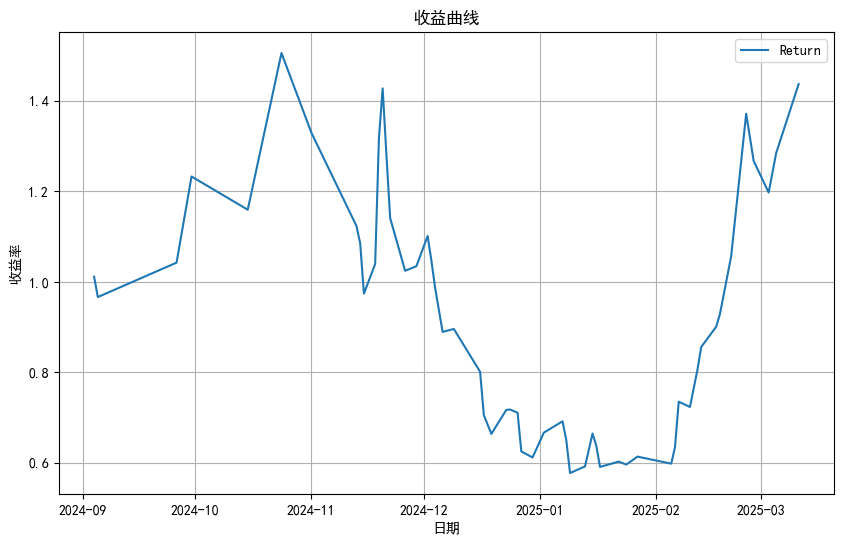

In [ ]:
plot(ddwndx, 'cumulative_returns')

In [ ]:
dwndx['r_pct'] = dwndx['real_open']/dwndx['open_price']

C:\Users\Administrator\AppData\Local\Temp\ipykernel_25500\2979096706.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dwndx['r_pct'] = dwndx['real_open']/dwndx['open_price']


In [ ]:
pd.set_option('display.max_columns', None)
dwndx.sort_values(by='r_pct', ascending=False)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_return,cumulative_returns,r_pct
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-19,1137,低吸,中位低吸,002403.XSHE,爱仕达,2,,,,-1,-1,-1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,2,0.0,60.42,182.68,0.0,-9.17,9.51,11.52,-1.0,11.90,12.67,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,-62.69,-23.70,48,60.39,-9.17,14,2025-02-15 18:39:58,10514256.0,0.251314,0.250314,0.332282,0.331282,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,9.99,0.267268,1.316634,1.050473
2025-01-07,359,低吸,中位低吸,002397.XSHE,梦洁股份,1,,,,-1,-1,-1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0.0,773.22,513.57,0.0,-0.53,3.74,4.14,-1.0,4.11,4.02,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,45.59,-16.03,5,37.70,-17.68,6,2025-02-15 19:23:59,37238259.0,0.098930,0.097930,0.074866,0.073866,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3.87,0.037760,0.691172,1.034759
2024-11-13,908,低吸,中位低吸,002858.XSHE,力盛体育,1,"000012.BKDL,000003.BKDL,000027.BKDL,000016.BKD...","885933.DDBK,886017.DDBK,886019.DDBK,886062.DDB...","980473.ZHBK,980355.ZHBK,980348.ZHBK",1,1,25,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,517.46,571.53,0.0,0.00,14.26,13.70,-1.0,13.18,12.43,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,86.45,-7.08,8,145.57,-3.51,2,2025-02-15 18:35:12,21311570.0,-0.075736,-0.076736,-0.128331,-0.129331,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,14.69,-0.154846,1.123242,1.030154
2024-11-20,1195,低吸,中位低吸,002757.XSHE,南兴股份,2,"000003.BKDL,000026.BKDL,000023.BKDL,000006.BKD...","885459.DDBK,885930.DDBK,885957.DDBK,885517.DDB...",980365.ZHBK,2,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0.0,834.66,511.08,0.0,-8.55,17.00,20.45,-1.0,19.80,19.00,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,-28.08,34.61,47,83.27,7.42,13,2025-02-15 18:41:11,88096176.0,0.164706,0.163706,0.117647,0.116647,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,17.51,0.084094,1.427355,1.030000
2024-11-01,150,低吸,中位低吸,603958.XSHG,哈森股份,2,,,,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,76.04,216.03,0.0,-6.09,14.50,13.90,-1.0,12.51,13.15,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,118.54,-1.62,13,161.16,-4.57,6,2025-02-15 18:23:35,12594700.0,-0.137241,-0.138241,-0.093103,-0.094103,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,14.88,-0.117263,1.329039,1.026207
2024-12-06,517,低吸,中位低吸,002689.XSHE,远大智能,3,"000026.BKDL,000035.BKDL,000034.BKDL,000013.BKD...","885641.DDBK,885517.DDBK,885783.DDBK,885941.DDB...",980365.ZHBK,1,1,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,158.96,264.18,0.0,-2.89,4.70,4.45,-1.0,4.25,4.34,-1.0,-1.0,-1.0,-1.0,0,0,9G0026,中位低吸,61.99,1.26,15,90.48,-4.32,15,2025-02-15 18:57:12,33180477.0,-0.095745,-0.096745,-0.076596,-0.077596,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,4.81,-0.098713,0.888840,1.023404
2024-09-30,1631,低吸,中位低吸,002583.XSHE,海能达,1,"000008.BKDL,000026.BKDL,000018.BKDL,000023.BKD...","885840.DDBK,885757.DDBK,885521.DDBK,885574.DDB...",980376.ZHBK,1,1,67,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,

<Axes: ylabel='Frequency'>

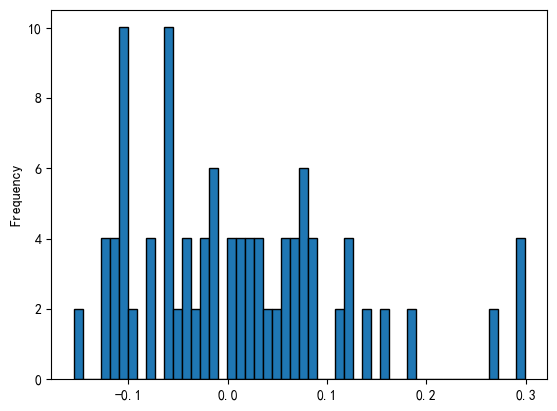

In [ ]:
ddwndx['r_return'].plot(kind='hist', bins=50, density=True, edgecolor='black')

In [ ]:
# 最大回撤: -14.59%
# 夏普比率: 0.29
# 总收益率: 234.78%
# 年化收益率: 722.40%
# 波动率: 5.95%
# 总盈亏: 235.83%
# 成功次数: 48
# 失败次数: 30
# 总天数: 78
# 总交易次数: 78
# 交易频率: 100.00%
# 胜率: 61.54%
# 平均盈利: 4.61%
# 平均亏损: -2.89%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.60
# 凯利公式最佳仓位: 37.43%

In [ ]:
# return:
# 最大回撤: -14.59%
# 夏普比率: 0.28
# 总收益率: 192.71%
# 年化收益率: 690.29%
# 波动率: 6.32%
# 总盈亏: 194.90%
# 成功次数: 41
# 失败次数: 26
# 总天数: 67
# 总交易次数: 67
# 交易频率: 100.00%
# 胜率: 61.19%
# 平均盈利: 4.87%
# 平均亏损: -3.05%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.60
# 凯利公式最佳仓位: 36.91%

In [ ]:
# return:
# 最大回撤: -14.83%
# 夏普比率: 0.31
# 总收益率: 192.83%
# 年化收益率: 784.38%
# 波动率: 6.57%
# 总盈亏: 195.02%
# 成功次数: 36
# 失败次数: 23
# 总天数: 59
# 总交易次数: 59
# 交易频率: 100.00%
# 胜率: 61.02%
# 平均盈利: 5.23%
# 平均亏损: -2.96%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.76
# 凯利公式最佳仓位: 38.92%
